In [1]:
pip install scikit-learn>=1.3.0 imbalanced-learn>=0.11.0 xgboost joblib pandas numpy matplotlib seaborn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, 
    average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load the training dataset
print("Loading cs-training.csv...")
df = pd.read_csv('/kaggle/input/give-me-some-credit-dataset/cs-training.csv')

# Drop the unnamed index column
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
    print("Dropped 'Unnamed: 0' column")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
df.head()

Loading cs-training.csv...
Dropped 'Unnamed: 0' column
Dataset shape: (150000, 11)
Columns: ['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

First 5 rows:


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
# Check for missing values
print("Missing Values:")
missing_info = df.isnull().sum()
print(missing_info[missing_info > 0])
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Check for invalid ages (age = 0)
print(f"\nRows with age <= 0: {(df['age'] <= 0).sum()}")
print(f"Age range: {df['age'].min()} to {df['age'].max()}")

# Target distribution
print(f"\nTarget Distribution (SeriousDlqin2yrs):")
target_dist = df['SeriousDlqin2yrs'].value_counts()
print(target_dist)
print(f"Default rate: {target_dist[1] / len(df) * 100:.2f}%")

Missing Values:
MonthlyIncome         29731
NumberOfDependents     3924
dtype: int64

Total missing values: 33655

Rows with age <= 0: 1
Age range: 0 to 109

Target Distribution (SeriousDlqin2yrs):
SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64
Default rate: 6.68%


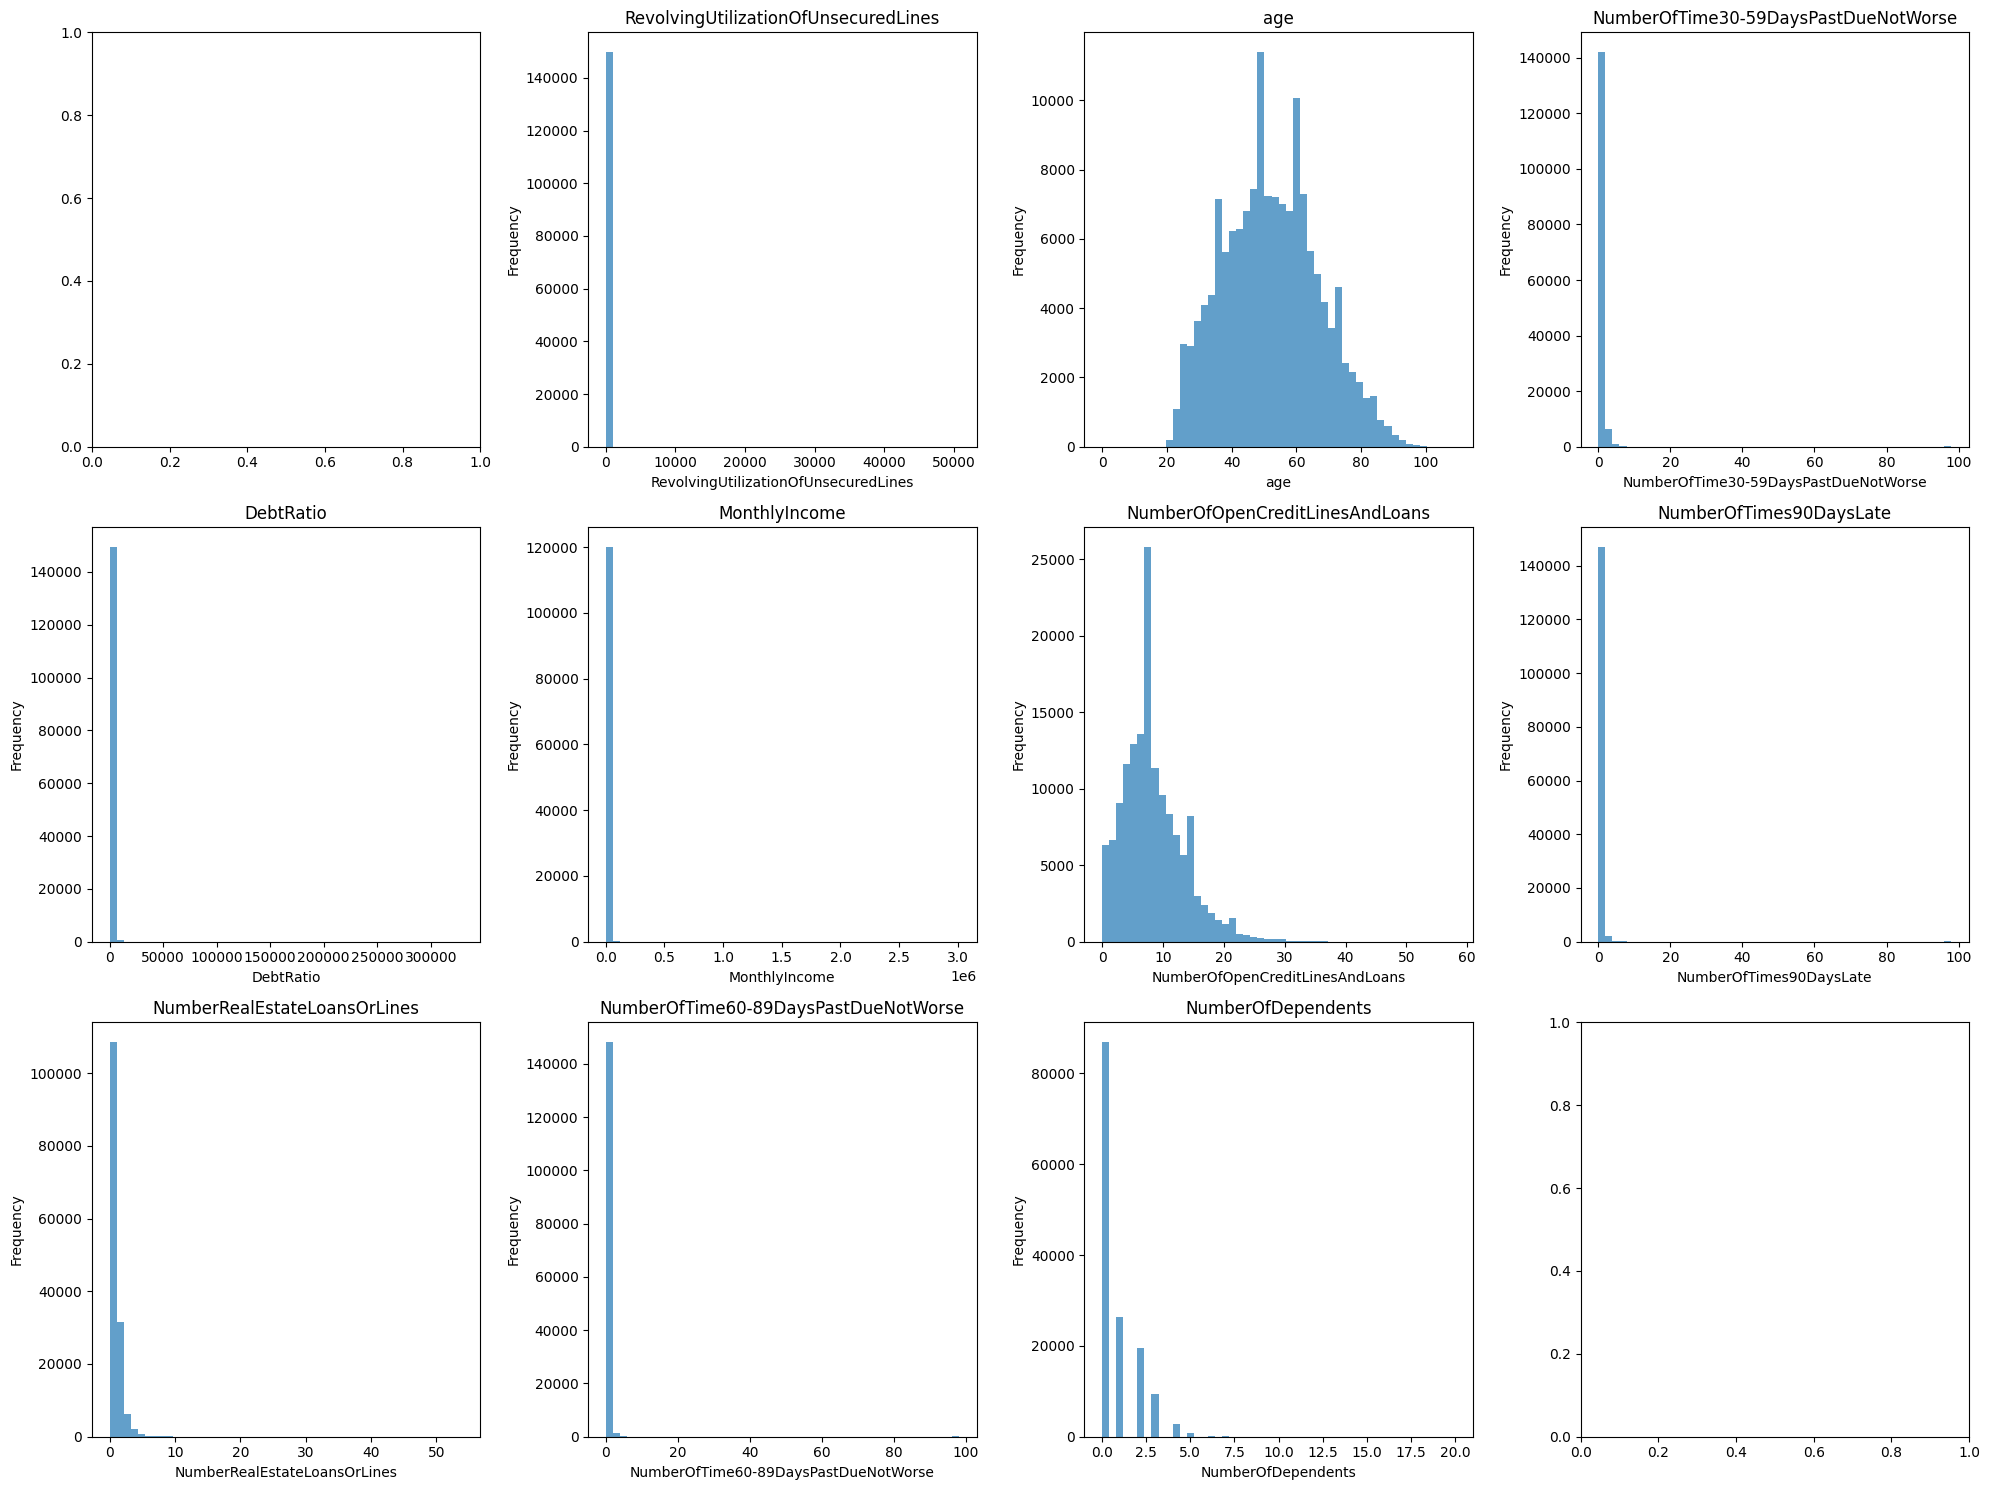


Extreme Outliers (99th percentile):
RevolvingUtilizationOfUnsecuredLines: 1500 values above 1.09
age: 1276 values above 87.00
NumberOfTime30-59DaysPastDueNotWorse: 850 values above 4.00
DebtRatio: 1500 values above 4979.04
MonthlyIncome: 1168 values above 25000.00
NumberOfOpenCreditLinesAndLoans: 1476 values above 24.00
NumberOfTimes90DaysLate: 873 values above 3.00
NumberRealEstateLoansOrLines: 1482 values above 4.00
NumberOfTime60-89DaysPastDueNotWorse: 755 values above 2.00
NumberOfDependents: 991 values above 4.00


In [5]:
# Visualize distributions to identify extreme outliers
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

for i, col in enumerate(df.select_dtypes(include=[np.number]).columns):
    if col != 'SeriousDlqin2yrs':  # Skip target variable
        axes[i].hist(df[col].dropna(), bins=50, alpha=0.7)
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Identify extreme outliers using percentiles
print("\nExtreme Outliers (99th percentile):")
for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'SeriousDlqin2yrs':
        p99 = df[col].quantile(0.99)
        extreme_outliers = (df[col] > p99).sum()
        print(f"{col}: {extreme_outliers} values above {p99:.2f}")

In [6]:
# Drop rows where age <= 0
print(f"Original dataset size: {len(df)}")
df_clean = df[df['age'] > 0].copy()
print(f"After removing invalid ages: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} rows with age <= 0")

Original dataset size: 150000
After removing invalid ages: 149999
Removed 1 rows with age <= 0


In [7]:
# Fill missing values with median
print("\nFilling missing values with median...")

# MonthlyIncome
if df_clean['MonthlyIncome'].isnull().sum() > 0:
    median_income = df_clean['MonthlyIncome'].median()
    df_clean['MonthlyIncome'].fillna(median_income, inplace=True)
    print(f"Filled {df_clean['MonthlyIncome'].isnull().sum()} missing MonthlyIncome values with median: {median_income}")

# NumberOfDependents
if df_clean['NumberOfDependents'].isnull().sum() > 0:
    median_dependents = df_clean['NumberOfDependents'].median()
    df_clean['NumberOfDependents'].fillna(median_dependents, inplace=True)
    print(f"Filled {df_clean['NumberOfDependents'].isnull().sum()} missing NumberOfDependents values with median: {median_dependents}")

print(f"\nRemaining missing values: {df_clean.isnull().sum().sum()}")


Filling missing values with median...
Filled 0 missing MonthlyIncome values with median: 5400.0
Filled 0 missing NumberOfDependents values with median: 0.0

Remaining missing values: 0


In [8]:
# Cap extreme outliers using 99th percentile for skewed columns
skewed_columns = [
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]

print("Capping extreme outliers at 99th percentile:")
for col in skewed_columns:
    if col in df_clean.columns:
        p99 = df_clean[col].quantile(0.99)
        outliers_before = (df_clean[col] > p99).sum()
        df_clean[col] = df_clean[col].clip(upper=p99)
        print(f"{col}: Capped {outliers_before} values at {p99:.2f}")

print("\nData cleaning completed!")

Capping extreme outliers at 99th percentile:
RevolvingUtilizationOfUnsecuredLines: Capped 1500 values at 1.09
DebtRatio: Capped 1500 values at 4979.08
NumberOfTime30-59DaysPastDueNotWorse: Capped 850 values at 4.00
NumberOfTime60-89DaysPastDueNotWorse: Capped 755 values at 2.00
NumberOfTimes90DaysLate: Capped 873 values at 3.00

Data cleaning completed!


In [9]:
# Define input features for modeling
feature_columns = [
    'RevolvingUtilizationOfUnsecuredLines', 'age',
    'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
    'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents'
]

print(f"Selected features: {feature_columns}")
print(f"Number of features: {len(feature_columns)}")

# Prepare feature matrix X and target vector y
X = df_clean[feature_columns].copy()
y = df_clean['SeriousDlqin2yrs'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature matrix info:")
X.info()

Selected features: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
Number of features: 10

Feature matrix shape: (149999, 10)
Target vector shape: (149999,)

Feature matrix info:
<class 'pandas.core.frame.DataFrame'>
Index: 149999 entries, 0 to 149999
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  149999 non-null  float64
 1   age                                   149999 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  149999 non-null  int64  
 3   DebtRatio                             149999 non-null  float64
 4   MonthlyIncome                         149999 non-null  float64
 5   NumberOf

In [10]:
# Scale features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)

print("Features scaled using StandardScaler")
print(f"Scaled features shape: {X_scaled.shape}")
print("\nScaled features summary:")
X_scaled.describe()

Features scaled using StandardScaler
Scaled features shape: (149999, 10)

Scaled features summary:


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,1.499990e+05,1.499990e+05,1.499990e+05,1.499990e+05,1.499990e+05,1.499990e+05,1.499990e+05,1.499990e+05,1.499990e+05,1.499990e+05
mean,3.903274e-17,6.177026e-17,-1.951637e-17,-2.917982e-17,2.122168e-17,7.200214e-18,1.515835e-18,6.338083e-17,4.926462e-18,3.410628e-18
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-9.101041e-01,-2.118680e+00,-3.687019e-01,-3.490231e-01,-4.979256e-01,-1.642608e+00,-2.153176e-01,-9.012765e-01,-2.177831e-01,-6.661191e-01
25%,-8.252906e-01,-7.646987e-01,-3.687019e-01,-3.488301e-01,-1.951420e-01,-6.709700e-01,-2.153176e-01,-9.012765e-01,-2.177831e-01,-6.661191e-01
50%,-4.722886e-01,-2.000882e-02,-3.687019e-01,-3.486190e-01,-7.900904e-02,-8.798698e-02,-2.153176e-01,-1.613911e-02,-2.177831e-01,-6.661191e-01
75%,6.774216e-01,7.246811e-01,-3.687019e-01,-3.480658e-01,7.614524e-02,4.949961e-01,-2.153176e-01,8.689983e-01,-2.177831e-01,2.372097e-01
max,2.193587e+00,3.838839e+00,5.629987e+00,5.140809e+00,2.329123e+02,9.628397e+00,7.253447e+00,4.689614e+01,6.676222e+00,1.740046e+01


In [11]:
# Train Isolation Forest for anomaly detection
print("Training Isolation Forest for anomaly detection...")

# Set contamination to approximate default rate (~6.7%)
default_rate = y.mean()
contamination = min(0.1, max(0.05, default_rate))  # Between 5% and 10%
print(f"Default rate: {default_rate:.3f}")
print(f"Setting contamination to: {contamination:.3f}")

# Train Isolation Forest
isolation_forest = IsolationForest(
    contamination=contamination,
    random_state=42,
    n_estimators=100
)

isolation_forest.fit(X_scaled)

# Generate anomaly predictions (-1 for anomaly, 1 for normal)
anomaly_predictions = isolation_forest.predict(X_scaled)

# Convert to binary flags (1 for anomaly, 0 for normal)
anomaly_flags = (anomaly_predictions == -1).astype(int)

print(f"\nAnomalies detected: {anomaly_flags.sum()} ({anomaly_flags.mean()*100:.2f}%)")
print(f"Normal instances: {(anomaly_flags == 0).sum()} ({(anomaly_flags == 0).mean()*100:.2f}%)")

Training Isolation Forest for anomaly detection...
Default rate: 0.067
Setting contamination to: 0.067

Anomalies detected: 10026 (6.68%)
Normal instances: 139973 (93.32%)


In [12]:
# Analyze relationship between anomalies and target
print("\nAnomaly Detection Analysis:")
anomalies_df = pd.DataFrame({
    'anomaly_flag': anomaly_flags,
    'target': y
})

# Cross-tabulation
print("\nCross-tabulation (Anomaly vs Target):")
crosstab = pd.crosstab(anomalies_df['anomaly_flag'], anomalies_df['target'], margins=True)
print(crosstab)

# Default rates by anomaly status
print("\nDefault rates by anomaly status:")
for anomaly_status in [0, 1]:
    subset = anomalies_df[anomalies_df['anomaly_flag'] == anomaly_status]
    default_rate = subset['target'].mean()
    status_name = "Normal" if anomaly_status == 0 else "Anomaly"
    print(f"{status_name}: {default_rate:.3f} ({default_rate*100:.1f}%)")


Anomaly Detection Analysis:

Cross-tabulation (Anomaly vs Target):
target             0      1     All
anomaly_flag                       
0             133410   6563  139973
1               6563   3463   10026
All           139973  10026  149999

Default rates by anomaly status:
Normal: 0.047 (4.7%)
Anomaly: 0.345 (34.5%)


In [13]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"Training default rate: {y_train.mean():.3f}")

# Handle class imbalance using SMOTE
print("\nApplying SMOTE for class balancing...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"Training set: {X_train_balanced.shape[0]} samples")
print(f"Class distribution:")
print(pd.Series(y_train_balanced).value_counts())
print(f"Balanced default rate: {y_train_balanced.mean():.3f}")

Training set: 119999 samples
Validation set: 30000 samples

Training set class distribution:
SeriousDlqin2yrs
0    111978
1      8021
Name: count, dtype: int64
Training default rate: 0.067

Applying SMOTE for class balancing...

After SMOTE:
Training set: 223956 samples
Class distribution:
SeriousDlqin2yrs
0    111978
1    111978
Name: count, dtype: int64
Balanced default rate: 0.500


In [14]:
# Train XGBoost classifier
print("Training XGBoost classifier...")

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("XGBoost training completed!")

# Generate risk scores (probability of default)
risk_scores_train = xgb_model.predict_proba(X_train)[:, 1]
risk_scores_val = xgb_model.predict_proba(X_val)[:, 1]
risk_scores_all = xgb_model.predict_proba(X_scaled)[:, 1]

print(f"\nRisk scores generated:")
print(f"Training risk scores range: {risk_scores_train.min():.4f} to {risk_scores_train.max():.4f}")
print(f"Validation risk scores range: {risk_scores_val.min():.4f} to {risk_scores_val.max():.4f}")
print(f"All risk scores range: {risk_scores_all.min():.4f} to {risk_scores_all.max():.4f}")

Training XGBoost classifier...
XGBoost training completed!

Risk scores generated:
Training risk scores range: 0.0053 to 0.9615
Validation risk scores range: 0.0064 to 0.9650
All risk scores range: 0.0053 to 0.9650



Feature Importance (XGBoost):
                                feature  importance
0  RevolvingUtilizationOfUnsecuredLines    0.214210
5       NumberOfOpenCreditLinesAndLoans    0.194578
6               NumberOfTimes90DaysLate    0.149725
2  NumberOfTime30-59DaysPastDueNotWorse    0.123522
8  NumberOfTime60-89DaysPastDueNotWorse    0.076048
1                                   age    0.075135
7          NumberRealEstateLoansOrLines    0.058799
3                             DebtRatio    0.038583
9                    NumberOfDependents    0.034702
4                         MonthlyIncome    0.034697


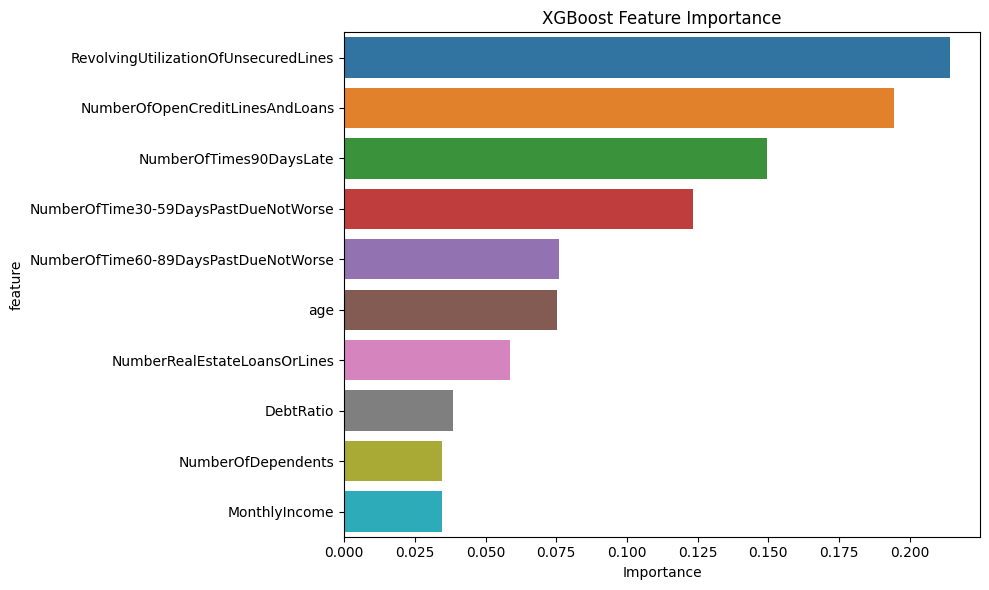

In [15]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (XGBoost):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [16]:
# Evaluate Isolation Forest (Anomaly Detection)
print("=== ISOLATION FOREST EVALUATION ===")
print("\nClassification Report (Anomaly Detection):")
print(classification_report(y, anomaly_flags, target_names=['Normal', 'Anomaly']))

if_accuracy = accuracy_score(y, anomaly_flags)
if_roc_auc = roc_auc_score(y, anomaly_flags)
if_avg_precision = average_precision_score(y, anomaly_flags)

print(f"\nIsolation Forest Metrics:")
print(f"Accuracy: {if_accuracy:.4f}")
print(f"ROC AUC: {if_roc_auc:.4f}")
print(f"Average Precision: {if_avg_precision:.4f}")

# Confusion Matrix
print("\nConfusion Matrix (Isolation Forest):")
if_cm = confusion_matrix(y, anomaly_flags)
print(if_cm)

=== ISOLATION FOREST EVALUATION ===

Classification Report (Anomaly Detection):
              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95    139973
     Anomaly       0.35      0.35      0.35     10026

    accuracy                           0.91    149999
   macro avg       0.65      0.65      0.65    149999
weighted avg       0.91      0.91      0.91    149999


Isolation Forest Metrics:
Accuracy: 0.9125
ROC AUC: 0.6493
Average Precision: 0.1631

Confusion Matrix (Isolation Forest):
[[133410   6563]
 [  6563   3463]]


In [17]:
# Evaluate XGBoost (Risk Scoring)
print("\n=== XGBOOST EVALUATION ===")

# Binary predictions using 0.5 threshold
xgb_predictions_val = (risk_scores_val > 0.5).astype(int)
xgb_predictions_all = (risk_scores_all > 0.5).astype(int)

print("\nValidation Set Performance:")
print(classification_report(y_val, xgb_predictions_val, target_names=['No Default', 'Default']))

val_accuracy = accuracy_score(y_val, xgb_predictions_val)
val_roc_auc = roc_auc_score(y_val, risk_scores_val)
val_avg_precision = average_precision_score(y_val, risk_scores_val)

print(f"\nValidation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"ROC AUC: {val_roc_auc:.4f}")
print(f"Average Precision: {val_avg_precision:.4f}")

# Full dataset performance
full_accuracy = accuracy_score(y, xgb_predictions_all)
full_roc_auc = roc_auc_score(y, risk_scores_all)
full_avg_precision = average_precision_score(y, risk_scores_all)

print(f"\nFull Dataset Metrics:")
print(f"Accuracy: {full_accuracy:.4f}")
print(f"ROC AUC: {full_roc_auc:.4f}")
print(f"Average Precision: {full_avg_precision:.4f}")


=== XGBOOST EVALUATION ===

Validation Set Performance:
              precision    recall  f1-score   support

  No Default       0.97      0.92      0.94     27995
     Default       0.34      0.55      0.42      2005

    accuracy                           0.90     30000
   macro avg       0.65      0.74      0.68     30000
weighted avg       0.92      0.90      0.91     30000


Validation Metrics:
Accuracy: 0.8992
ROC AUC: 0.8567
Average Precision: 0.3567

Full Dataset Metrics:
Accuracy: 0.9022
ROC AUC: 0.8680
Average Precision: 0.3884


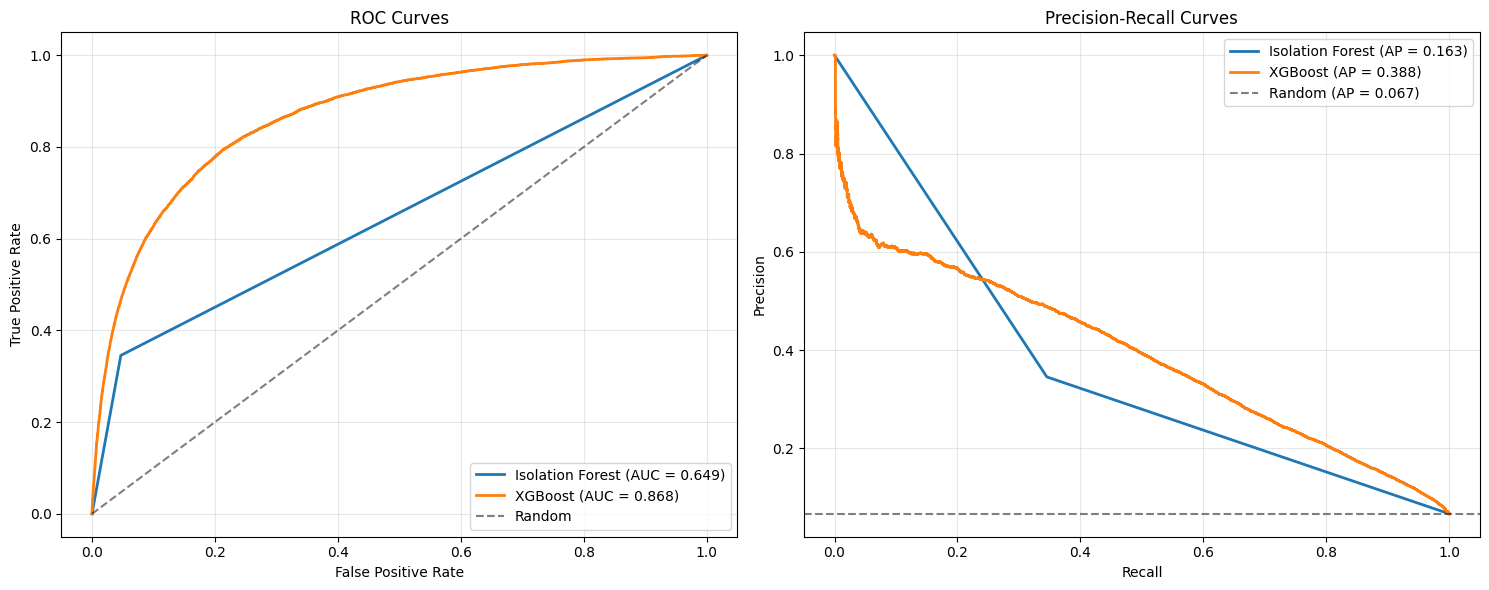

In [18]:
# Plot ROC and Precision-Recall curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
fpr_if, tpr_if, _ = roc_curve(y, anomaly_flags)
fpr_xgb, tpr_xgb, _ = roc_curve(y, risk_scores_all)

ax1.plot(fpr_if, tpr_if, label=f'Isolation Forest (AUC = {if_roc_auc:.3f})', linewidth=2)
ax1.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {full_roc_auc:.3f})', linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
precision_if, recall_if, _ = precision_recall_curve(y, anomaly_flags)
precision_xgb, recall_xgb, _ = precision_recall_curve(y, risk_scores_all)

ax2.plot(recall_if, precision_if, label=f'Isolation Forest (AP = {if_avg_precision:.3f})', linewidth=2)
ax2.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {full_avg_precision:.3f})', linewidth=2)
ax2.axhline(y=y.mean(), color='k', linestyle='--', alpha=0.5, label=f'Random (AP = {y.mean():.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Model Comparison Summary
print("\n=== MODEL COMPARISON SUMMARY ===")
comparison_df = pd.DataFrame({
    'Model': ['Isolation Forest', 'XGBoost'],
    'Accuracy': [if_accuracy, full_accuracy],
    'ROC AUC': [if_roc_auc, full_roc_auc],
    'Average Precision': [if_avg_precision, full_avg_precision]
})

print(comparison_df.round(4))

# Determine best model
best_model_idx = comparison_df['ROC AUC'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
print(f"\nBest performing model: {best_model} (ROC AUC: {comparison_df.loc[best_model_idx, 'ROC AUC']:.4f})")


=== MODEL COMPARISON SUMMARY ===
              Model  Accuracy  ROC AUC  Average Precision
0  Isolation Forest    0.9125   0.6493             0.1631
1           XGBoost    0.9022   0.8680             0.3884

Best performing model: XGBoost (ROC AUC: 0.8680)


In [20]:
# Create final output combining anomaly flags and risk scores
print("\n=== FINAL OUTPUT GENERATION ===")

# Combine results
final_results = pd.DataFrame({
    'anomaly_flag': anomaly_flags,
    'risk_score': risk_scores_all
})

print(f"Final results shape: {final_results.shape}")
print(f"\nSample output:")
print(final_results.head(10))

# Save to CSV
output_file = 'risk_anomaly_predictions.csv'
final_results.to_csv(output_file, index=False)
print(f"\nResults saved to: {output_file}")

# Summary statistics
print(f"\nOutput Summary:")
print(f"Anomalies detected: {final_results['anomaly_flag'].sum()} ({final_results['anomaly_flag'].mean()*100:.2f}%)")
print(f"Risk score range: {final_results['risk_score'].min():.4f} to {final_results['risk_score'].max():.4f}")
print(f"Mean risk score: {final_results['risk_score'].mean():.4f}")
print(f"Median risk score: {final_results['risk_score'].median():.4f}")


=== FINAL OUTPUT GENERATION ===
Final results shape: (149999, 2)

Sample output:
   anomaly_flag  risk_score
0             1    0.745920
1             0    0.394334
2             0    0.665596
3             0    0.106662
4             1    0.331848
5             0    0.054476
6             0    0.078911
7             0    0.326785
8             0    0.090513
9             0    0.249062

Results saved to: risk_anomaly_predictions.csv

Output Summary:
Anomalies detected: 10026 (6.68%)
Risk score range: 0.0053 to 0.9650
Mean risk score: 0.1959
Median risk score: 0.1110


In [21]:
# Save models and preprocessing components
print("Saving models and preprocessing components...")

# Save models
joblib.dump(isolation_forest, 'isolation_forest_model.pkl')
joblib.dump(xgb_model, 'xgboost_risk_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

# Save feature columns for consistency
joblib.dump(feature_columns, 'feature_columns.pkl')

print("\nSaved files:")
print("- isolation_forest_model.pkl")
print("- xgboost_risk_model.pkl")
print("- feature_scaler.pkl")
print("- feature_columns.pkl")

# Verify saved models
print("\nVerifying saved models...")
try:
    loaded_if = joblib.load('isolation_forest_model.pkl')
    loaded_xgb = joblib.load('xgboost_risk_model.pkl')
    loaded_scaler = joblib.load('feature_scaler.pkl')
    loaded_features = joblib.load('feature_columns.pkl')
    print("✓ All models loaded successfully!")
except Exception as e:
    print(f"✗ Error loading models: {e}")

Saving models and preprocessing components...

Saved files:
- isolation_forest_model.pkl
- xgboost_risk_model.pkl
- feature_scaler.pkl
- feature_columns.pkl

Verifying saved models...
✓ All models loaded successfully!


In [22]:
def predict_risk(borrower_profile):
    """
    Predict risk score and anomaly flag for a new borrower profile.
    
    Parameters:
    -----------
    borrower_profile : pandas.DataFrame or dict
        Borrower data with the required features:
        ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 
         'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 
         'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 
         'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'anomaly_flag': int (0 = normal, 1 = anomaly)
        - 'risk_score': float (0-1, probability of default)
    """
    try:
        # Convert to DataFrame if dictionary
        if isinstance(borrower_profile, dict):
            borrower_df = pd.DataFrame([borrower_profile])
        else:
            borrower_df = borrower_profile.copy()
        
        # Ensure all required features are present
        required_features = [
            'RevolvingUtilizationOfUnsecuredLines', 'age',
            'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
            'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
            'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
            'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents'
        ]
        
        missing_features = [f for f in required_features if f not in borrower_df.columns]
        if missing_features:
            raise ValueError(f"Missing required features: {missing_features}")
        
        # Select and order features
        X_new = borrower_df[required_features]
        
        # Scale features
        X_new_scaled = scaler.transform(X_new)
        
        # Predict anomaly
        anomaly_pred = isolation_forest.predict(X_new_scaled)
        anomaly_flag = int(anomaly_pred[0] == -1)  # -1 = anomaly, 1 = normal
        
        # Predict risk score
        risk_score = float(xgb_model.predict_proba(X_new_scaled)[0, 1])
        
        return {
            'anomaly_flag': anomaly_flag,
            'risk_score': risk_score
        }
        
    except Exception as e:
        return {
            'error': str(e),
            'anomaly_flag': None,
            'risk_score': None
        }

print("predict_risk() function defined successfully!")

predict_risk() function defined successfully!


In [23]:
# Test the predict_risk function with sample borrower profiles
print("=== TESTING predict_risk() FUNCTION ===")

# Test case 1: Normal borrower profile
sample_borrower_1 = {
    'RevolvingUtilizationOfUnsecuredLines': 0.3,
    'age': 45,
    'NumberOfTime30-59DaysPastDueNotWorse': 0,
    'DebtRatio': 0.2,
    'MonthlyIncome': 6000,
    'NumberOfOpenCreditLinesAndLoans': 8,
    'NumberOfTimes90DaysLate': 0,
    'NumberRealEstateLoansOrLines': 1,
    'NumberOfTime60-89DaysPastDueNotWorse': 0,
    'NumberOfDependents': 2
}

result_1 = predict_risk(sample_borrower_1)
print(f"\nTest 1 - Normal Borrower:")
print(f"Input: {sample_borrower_1}")
print(f"Output: {result_1}")

# Test case 2: High-risk borrower profile
sample_borrower_2 = {
    'RevolvingUtilizationOfUnsecuredLines': 0.95,
    'age': 25,
    'NumberOfTime30-59DaysPastDueNotWorse': 3,
    'DebtRatio': 0.8,
    'MonthlyIncome': 2000,
    'NumberOfOpenCreditLinesAndLoans': 15,
    'NumberOfTimes90DaysLate': 2,
    'NumberRealEstateLoansOrLines': 0,
    'NumberOfTime60-89DaysPastDueNotWorse': 1,
    'NumberOfDependents': 4
}

result_2 = predict_risk(sample_borrower_2)
print(f"\nTest 2 - High-Risk Borrower:")
print(f"Input: {sample_borrower_2}")
print(f"Output: {result_2}")

# Test case 3: Using DataFrame input
sample_df = pd.DataFrame([sample_borrower_1, sample_borrower_2])
print(f"\nTest 3 - DataFrame Input (2 borrowers):")
for i, row in sample_df.iterrows():
    result = predict_risk(row.to_frame().T)
    print(f"Borrower {i+1}: {result}")

=== TESTING predict_risk() FUNCTION ===

Test 1 - Normal Borrower:
Input: {'RevolvingUtilizationOfUnsecuredLines': 0.3, 'age': 45, 'NumberOfTime30-59DaysPastDueNotWorse': 0, 'DebtRatio': 0.2, 'MonthlyIncome': 6000, 'NumberOfOpenCreditLinesAndLoans': 8, 'NumberOfTimes90DaysLate': 0, 'NumberRealEstateLoansOrLines': 1, 'NumberOfTime60-89DaysPastDueNotWorse': 0, 'NumberOfDependents': 2}
Output: {'anomaly_flag': 0, 'risk_score': 0.05416058376431465}

Test 2 - High-Risk Borrower:
Input: {'RevolvingUtilizationOfUnsecuredLines': 0.95, 'age': 25, 'NumberOfTime30-59DaysPastDueNotWorse': 3, 'DebtRatio': 0.8, 'MonthlyIncome': 2000, 'NumberOfOpenCreditLinesAndLoans': 15, 'NumberOfTimes90DaysLate': 2, 'NumberRealEstateLoansOrLines': 0, 'NumberOfTime60-89DaysPastDueNotWorse': 1, 'NumberOfDependents': 4}
Output: {'anomaly_flag': 1, 'risk_score': 0.9063896536827087}

Test 3 - DataFrame Input (2 borrowers):
Borrower 1: {'anomaly_flag': 0, 'risk_score': 0.05416058376431465}
Borrower 2: {'anomaly_flag': 1

In [24]:
# Production-ready wrapper for LLM agent integration
def get_risk_score(input_data):
    """
    Production wrapper for LLM agent integration.
    
    This function matches the expected interface for LangChain-style tools:
    {
      "tool_name": "get_risk_score",
      "input": {
        "MonthlyIncome": 6000,
        "age": 45,
        ...
      },
      "output": {
        "anomaly_flag": 1,
        "risk_score": 0.834
      }
    }
    
    Parameters:
    -----------
    input_data : dict
        Dictionary containing borrower features
    
    Returns:
    --------
    dict
        Standardized output with anomaly_flag and risk_score
    """
    try:
        # Use the predict_risk function
        result = predict_risk(input_data)
        
        # Ensure consistent output format
        if 'error' in result:
            return {
                'anomaly_flag': -1,  # Error indicator
                'risk_score': -1.0,  # Error indicator
                'error': result['error']
            }
        
        return {
            'anomaly_flag': result['anomaly_flag'],
            'risk_score': round(result['risk_score'], 4)
        }
        
    except Exception as e:
        return {
            'anomaly_flag': -1,
            'risk_score': -1.0,
            'error': str(e)
        }

print("get_risk_score() wrapper function defined for LLM integration!")

# Test the wrapper
test_input = {
    "MonthlyIncome": 6000,
    "age": 45,
    "RevolvingUtilizationOfUnsecuredLines": 0.3,
    "NumberOfTime30-59DaysPastDueNotWorse": 0,
    "DebtRatio": 0.2,
    "NumberOfOpenCreditLinesAndLoans": 8,
    "NumberOfTimes90DaysLate": 0,
    "NumberRealEstateLoansOrLines": 1,
    "NumberOfTime60-89DaysPastDueNotWorse": 0,
    "NumberOfDependents": 2
}

wrapper_result = get_risk_score(test_input)
print(f"\nWrapper Test:")
print(f"Input: {test_input}")
print(f"Output: {wrapper_result}")

get_risk_score() wrapper function defined for LLM integration!

Wrapper Test:
Input: {'MonthlyIncome': 6000, 'age': 45, 'RevolvingUtilizationOfUnsecuredLines': 0.3, 'NumberOfTime30-59DaysPastDueNotWorse': 0, 'DebtRatio': 0.2, 'NumberOfOpenCreditLinesAndLoans': 8, 'NumberOfTimes90DaysLate': 0, 'NumberRealEstateLoansOrLines': 1, 'NumberOfTime60-89DaysPastDueNotWorse': 0, 'NumberOfDependents': 2}
Output: {'anomaly_flag': 0, 'risk_score': 0.0542}
